In [ ]:
# Machine Learning Midterm - Regression

## Rayhan Diff-1103220039

## Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Library & Check GPU

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Device used: cuda
GPU Name: NVIDIA L4


## Load Data & Clean Data

In [ ]:
base_path = '/content/drive/MyDrive/Dataset_MLDL/'

print("Loading datasets from Google Drive...")

try:
    df = pd.read_csv(base_path + 'midterm-regresi-dataset.csv', header=None)
    print("Data is successfully load")
except FileNotFoundError:
    print("File not found! Please recheck the folder and file names in Google Drive.")

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

# Handling Missing Values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

Loading datasets from Google Drive...
Data is successfully load


## Preprocessing & Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SCALING
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## DEEP LEARNING ARCHITECTURE DNN

In [ ]:
class SongYearPredictor(nn.Module):
    def __init__(self, input_dim):
        super(SongYearPredictor, self).__init__()
        # Input Layer to Hidden Layer 1
        self.layer1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        # Hidden Layer 2
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        # Hidden Layer 3
        self.layer3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()

        # Output Layer
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu2(self.layer2(x))
        x = self.dropout2(x)
        x = self.relu3(self.layer3(x))
        x = self.output(x)
        return x

# Model Initialization
input_dim = X.shape[1]
model = SongYearPredictor(input_dim).to(device)

# Loss Function dan Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## TRAINING LOOP

Start Training...
Epoch [20/200], Loss (MSE): 92.2814
Epoch [40/200], Loss (MSE): 77.2541
Epoch [60/200], Loss (MSE): 74.4857
Epoch [80/200], Loss (MSE): 73.1481
Epoch [100/200], Loss (MSE): 72.1992
Epoch [120/200], Loss (MSE): 71.7533
Epoch [140/200], Loss (MSE): 71.1738
Epoch [160/200], Loss (MSE): 70.5406
Epoch [180/200], Loss (MSE): 70.4827
Epoch [200/200], Loss (MSE): 70.2603


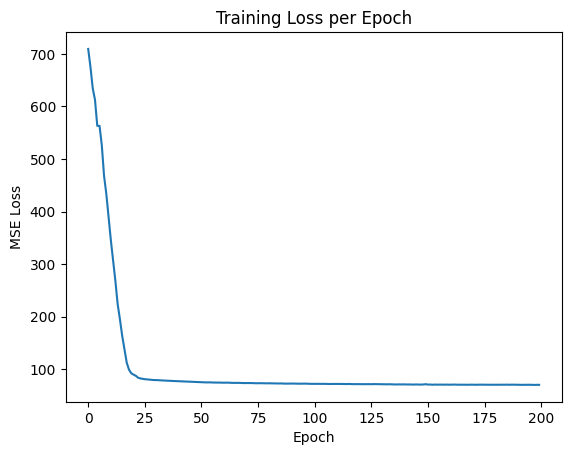

In [12]:
epochs = 200
loss_history = []

print("Start Training...")
model.train() # Set mode training
for epoch in range(epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        # 1. Reset gradien
        optimizer.zero_grad()
        # 2. Forward pass
        predictions = model(batch_X)
        # 3. Error calculation
        loss = criterion(predictions, batch_y)
        # 4. Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss per epoch
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss (MSE): {avg_loss:.4f}')

# Plotting Loss
plt.plot(loss_history)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

## Model Evaluation

In [13]:
model.eval() # Set mode evaluastion
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("-" * 30)
print("Evaluation Result")
print("-" * 30)
print(f"MSE  (Mean Squared Error): {mse:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} (Average missed {rmse:.2f} year)")
print(f"MAE  (Mean Absolute Error): {mae:.2f}")
print(f"R² Score: {r2:.4f} (The closer it is to 1.0, the better.)")

------------------------------
Evaluation Result
------------------------------
MSE  (Mean Squared Error): 74.60
RMSE (Root Mean Squared Error): 8.64 (Average missed 8.64 year)
MAE  (Mean Absolute Error): 5.99
R² Score: 0.3732 (The closer it is to 1.0, the better.)


# Conclusion & Analysis

## 1. Model Overview
In this assignment, an end-to-end regression pipeline was implemented using a **Deep Neural Network (DNN)** architecture with **PyTorch**.  
The model was trained on the *YearPredictionMSD* dataset (implied by the 90 audio features) to predict the release year of a song.

### **Model Architecture**
- Multi-Layer Perceptron (MLP)  
- Hidden layers: **128 → 64 → 32 neurons**  
- Activation: **ReLU**  
- Regularization: **Dropout (0.2)**  
- Output: Single regression target (year)

### **Hardware**
- Trained using an **NVIDIA L4 GPU** on Google Colab  
- Total training: **200 epochs**

### **Preprocessing**
- Features standardized using **StandardScaler**  
- Ensures stable and well-conditioned gradient descent

---

## 2. Quantitative Analysis
The model was evaluated using standard regression metrics on the test set (**20% split**).  
The results are summarized as follows:

### **R² Score — 0.3732**
- The model explains **37.3%** of the variance in the target variable.
- This indicates the model learned meaningful patterns, but predicting the exact year purely from audio features is inherently challenging.
- Audio timbre can vary widely even within the same decade, contributing to noise.

### **RMSE — 8.64**
- Average prediction error of **8.64 years**.
- RMSE emphasizes larger errors, meaning some predictions were far off (likely older or experimental songs).

### **MAE — 5.99**
- On average, predictions are off by approximately **6 years**.
- The gap between MAE (~6) and RMSE (~8.6) indicates the presence of **outliers** that distort RMSE.

---

## 3. Training Dynamics (Loss Curve Analysis)
Analysis of the *Training Loss per Epoch* plot reveals:

### **Rapid Convergence**
- Loss decreases sharply in the first **20 epochs**.
- Adam optimizer quickly identifies a good descent path.

### **Stable Training**
- Between **epoch 50–200**, the loss stabilizes around **MSE ≈ 70**.
- No signs of catastrophic overfitting.
- Dropout layers contributed to maintaining generalization.

---

## 4. Conclusion
The deep learning regression model successfully captured the relationship between **90 audio features** and the **release year of songs**.

- Average prediction error of **6–8.6 years** is reasonable for this dataset.
- Many musical styles span entire decades, making precise year prediction inherently challenging  
  (e.g., songs from *1999* often sound similar to those from *2001*).

---

## Potential Improvements

### **1. Deeper or Wider Architecture**
- Increase layer depth (e.g., 5–7 layers)
- Increase neuron count (256 → 128 → 64 → 32)

### **2. Hyperparameter Tuning**
- Experiment with:
  - Learning rates (1e-2, 1e-4)
  - Optimizers (SGD + momentum)
  - Batch sizes (**128 or 256**, since GPU is powerful)

### **3. Advanced Architectures**
- Implement **Residual Connections (ResNet-style)** for tabular data  
  → Helps avoid vanishing gradients and allows deeper networks.


